# Forecasting

## - Apa itu Forecasting?

Bayangkan Anda adalah seorang kapten kapal yang mencoba menavigasi lautan yang tidak pasti di depan. Untuk tahu ke mana harus berlayar, Anda tidak bisa hanya menebak-nebak; Anda harus melihat ke belakang, mempelajari catatan perjalanan sebelumnya, menganalisis pola angin musiman, dan data arus laut yang telah dikumpulkan. Inilah inti dari forecasting (peramalan): sebuah proses sistematis untuk memprediksi apa yang akan terjadi di masa depan dengan cara menggali dan menganalisis data historis serta tren masa lalu. Baik itu untuk memperkirakan cuaca besok, penjualan produk bulan depan, atau, seperti dalam kasus Anda, memprediksi tingkat polusi $NO_2$, tujuannya selalu sama—yaitu menggunakan wawasan dari masa lalu untuk mengurangi ketidakpastian dan membantu kita mengambil keputusan yang lebih cerdas dan lebih siap hari ini.

## - Mengapa Forecasting penting?

Pada intinya, kita melihat pola-pola yang terjadi di masa lalu (seperti tren musiman, siklus, atau kebiasaan) dan menggunakan pola tersebut untuk membuat perkiraan yang logis tentang apa yang akan terjadi selanjutnya.Tujuan utamanya adalah untuk mengurangi ketidakpastian dalam pengambilan keputusan. Dengan memiliki perkiraan yang berbasis data, sebuah organisasi atau individu dapat membuat perencanaan yang lebih matang, mengantisipasi risiko, dan mengalokasikan sumber daya secara lebih efisien.

## - Crawling Data

### 1. Import libarary yang dibutuhkan

In [1]:
import openeo
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import xarray as xr

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()
print("Connected to Copernicus Data Space Ecosystem")

Authenticated using refresh token.
Connected to Copernicus Data Space Ecosystem


### 2. Definisi kan koordinat di wilayah Kamal dan parameter waktu (2022-2025)

In [2]:
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              112.71199080623381,
              -7.151070739706199
            ],
            [
              112.71199080623381,
              -7.168985131602568
            ],
            [
              112.73980259222657,
              -7.168985131602568
            ],
            [
              112.73980259222657,
              -7.151070739706199
            ],
            [
              112.71199080623381,
              -7.151070739706199
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

# Define spatial extent from AOI coordinates
spatial_extent = {
    "west": 112.71199080623381,
    "south": -7.168985131602568,
    "east": 112.73980259222657,
    "north": -7.151070739706199
}

start_date = "2022-10-23"
end_date = "2025-10-23"

print(f"AOI defined for coordinates: {spatial_extent}")
print(f"Time range: {start_date} to {end_date}")
print("Setup completed successfully")

AOI defined for coordinates: {'west': 112.71199080623381, 'south': -7.168985131602568, 'east': 112.73980259222657, 'north': -7.151070739706199}
Time range: 2022-10-23 to 2025-10-23
Setup completed successfully


### 3. Loading data Sentinel-5P NO2 dan agregasi temporal harian

In [3]:
print("Loading Sentinel-5P NO2 data...")

s5p_no2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=[start_date, end_date],
    spatial_extent=spatial_extent,
    bands=["NO2"],
)

s5p_monthly = s5p_no2.aggregate_temporal_period(
    period="day",
    reducer="mean"
)

print("Data collection and aggregation configured successfully")

Loading Sentinel-5P NO2 data...


Data collection and aggregation configured successfully


### 4. Melakukan eksekusi job batch processing untuk memproses data secara otomatis dan terjadwal, kemudian mengekspor hasilnya ke dalam format file NetCDF

In [4]:
print("Starting data processing job...")

job = s5p_monthly.execute_batch(
    title="NO2 Averages 2021-2025", 
    outputfile="no2_averages_4years.nc"
)


Starting data processing job...


0:00:00 Job 'j-2512190225384b498b124b05ca96658b': send 'start'


0:00:15 Job 'j-2512190225384b498b124b05ca96658b': created (progress 0%)


0:00:20 Job 'j-2512190225384b498b124b05ca96658b': created (progress 0%)


0:00:27 Job 'j-2512190225384b498b124b05ca96658b': created (progress 0%)


### 5. Ubah data NetCDF ke CSV agar lebih mudah untuk digunakan

In [3]:
# 1. Buka file .nc Anda
# Ganti 'openEO.nc' jika nama filenya berbeda
ds = xr.open_dataset("C:\\Dokumen\\PSD\\dataset\\openEO.nc")

# 2. Konversi dataset xarray menjadi DataFrame pandas
df = ds.to_dataframe()

# 3. [PENTING] Ratakan Multi-Index
# Data NetCDF biasanya punya banyak index (spt waktu, lat, lon).
# 'reset_index()' akan mengubah semua index itu menjadi kolom biasa.
df_flat = df.reset_index()

# 4. Simpan sebagai file CSV
df_flat.to_csv('hasil_data_no2.csv', index=False)

print("Selesai! File 'hasil_data_no2.csv' telah dibuat.")

Selesai! File 'hasil_data_no2.csv' telah dibuat.


## - Preprocessing

### - Mengurutkan Data berdasarkan tanggal/waktu

Mengurutkan data berdasarkan tanggal/waktu (sortir kronologis) adalah langkah preprocessing yang fundamental, terutama untuk data time-series (data berurutan).

Ini penting karena mengubah data yang acak menjadi sebuah alur cerita yang logis.

Tujuannya adalah untuk memastikan bahwa setiap observasi (baris data) ditempatkan dalam urutan yang benar sesuai kejadiannya. Tanpa pengurutan ini, analisis seperti mencari tren, mengidentifikasi pola musiman, atau melakukan interpolasi (mengisi data hilang) akan menghasilkan kesimpulan yang salah, karena hubungan antar-waktu antar-titik data menjadi rusak.

In [4]:
# 1. Baca file CSV
df = pd.read_csv('hasil_data_no2.csv')

# 2. Ubah kolom 't' menjadi format datetime
df['t'] = pd.to_datetime(df['t'])

# 3. Urutkan DataFrame berdasarkan kolom 't'
df_sorted = df.sort_values(by='t')

# 4. Menampilkan hasil pengirutan
print(df_sorted)

print("Selesai! Data telah diurutkan berdasarkan waktu dan disimpan di 'hasil_data_no2_sorted.csv'")

              t           x         y  crs       NO2
0    2022-10-23  112.739273 -7.151624  b''  0.000030
1    2022-10-24  112.739273 -7.151624  b''       NaN
2    2022-10-25  112.739273 -7.151624  b''  0.000070
3    2022-10-26  112.739273 -7.151624  b''       NaN
4    2022-10-27  112.739273 -7.151624  b''       NaN
...         ...         ...       ...  ...       ...
1085 2025-10-18  112.739273 -7.151624  b''  0.000015
1086 2025-10-19  112.739273 -7.151624  b''  0.000056
1087 2025-10-20  112.739273 -7.151624  b''       NaN
1088 2025-10-21  112.739273 -7.151624  b''       NaN
1089 2025-10-22  112.739273 -7.151624  b''       NaN

[1090 rows x 5 columns]
Selesai! Data telah diurutkan berdasarkan waktu dan disimpan di 'hasil_data_no2_sorted.csv'


### - Mengatasi Missing Value dengan interpolasi

Mengatasi *missing value* (data hilang) dengan **interpolasi** adalah teknik *preprocessing* untuk "menebak" nilai yang hilang secara cerdas.

Cara kerjanya adalah dengan **melihat nilai-nilai tetangga yang diketahui** (misalnya, nilai sebelum dan sesudah data yang hilang) dan menarik garis lurus (atau kurva) di antara keduanya. Nilai yang hilang kemudian diisi dengan titik yang jatuh tepat di atas garis tersebut.

Ini adalah metode yang sangat umum untuk data *time-series* (seperti data cuaca atau polusi) karena metode ini **mempertahankan kelancaran dan tren data** dari waktu ke waktu, alih-alih hanya mengisi dengan nilai rata-rata atau membuang baris data.

In [5]:

df_indexed = df_sorted.set_index('t')

# 5. Lakukan interpolasi pada kolom 'NO2'
df_indexed['NO2'] = df_indexed['NO2'].interpolate(method='time')

# 6. Kembalikan 't' menjadi kolom & simpan di variabel baru
df_interpolated = df_indexed.reset_index()


# --- Konfirmasi Hasil ---
print("Selesai! Data sudah diinterpolasi dan disimpan dalam variabel 'df_interpolated'.")
print("\nCuplikan 5 baris pertama dari data hasil interpolasi:")
print(df_interpolated.head())
print(f"\nSisa missing values di kolom 'NO2': {df_interpolated['NO2'].isna().sum()}")

Selesai! Data sudah diinterpolasi dan disimpan dalam variabel 'df_interpolated'.

Cuplikan 5 baris pertama dari data hasil interpolasi:
           t           x         y  crs       NO2
0 2022-10-23  112.739273 -7.151624  b''  0.000030
1 2022-10-24  112.739273 -7.151624  b''  0.000050
2 2022-10-25  112.739273 -7.151624  b''  0.000070
3 2022-10-26  112.739273 -7.151624  b''  0.000057
4 2022-10-27  112.739273 -7.151624  b''  0.000045

Sisa missing values di kolom 'NO2': 0


In [6]:
# Analisis Nilai Outlier pada Data NO2
no2_values = df_interpolated['NO2']
q1 = no2_values.quantile(0.25)
q3 = no2_values.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df_interpolated[(no2_values < lower_bound) | (no2_values > upper_bound)]

# --- Konfirmasi Hasil ---
print(f"Selesai! Ditemukan {len(outliers)} nilai outlier pada data NO2.")
# Imputasi Nilai Outlier dengan Metode Median
df_no_outliers = df_interpolated.copy()
median_no2 = df_no_outliers['NO2'].median()
df_no_outliers.loc[(df_no_outliers['NO2'] < lower_bound) | (df_no_outliers['NO2'] > upper_bound), 'NO2'] = median_no2
print("Selesai! Nilai outlier telah diimputasi dengan median NO2.")

Selesai! Ditemukan 51 nilai outlier pada data NO2.
Selesai! Nilai outlier telah diimputasi dengan median NO2.


### - Mengubah data time series ke data supervised

Mengubah data time-series menjadi supervised adalah proses preprocessing untuk menggeser data (lagging) agar bisa digunakan untuk machine learning.Pada dasarnya, Anda mengubah satu kolom data (misalnya, $NO_2$) menjadi format "input-output".Anda mengambil nilai-nilai dari hari-hari sebelumnya (misalnya, $t-1$, $t-2$, $t-3$) sebagai fitur (X), dan menggunakan nilai hari ini ($t$) sebagai target (y) yang ingin diprediksi.Proses ini mengubah data dari:[Nilai hari ini]Menjadi:[Nilai kemarin, Nilai 2 hari lalu, Nilai 3 hari lalu] -> [Nilai hari ini]

In [7]:
# Mulai dengan DataFrame 'df_interpolated' dari langkah sebelumnya
# 1. Pilih hanya kolom waktu ('t') dan nilai ('NO2')
data = df_interpolated[['t', 'NO2']].copy()

# 2. Tentukan berapa banyak lag yang ingin Anda buat (misalnya: 3 hari sebelumnya)
N_LAGS = 3

# 3. Buat fitur lag (geser data ke bawah)
for i in range(1, N_LAGS + 1):
    data[f'NO2(t-{i})'] = data['NO2'].shift(i)

# 4. Ganti nama kolom 'NO2' asli menjadi target (y)
data.rename(columns={'NO2': 'NO2_target(t)'}, inplace=True)

# 5. Hapus baris yang mengandung NaN
# Ini adalah N_LAGS baris pertama, yang tidak memiliki data historis
data.dropna(inplace=True)

# 6. Reset index agar rapi
data.reset_index(drop=True, inplace=True)

# 7. Simpan hasil akhir ke variabel baru 'df_supervised'
df_supervised = data

# 8. Tampilkan hasilnya
print(f"Selesai! DataFrame 'df_supervised' telah dibuat dengan {N_LAGS} lag features.")
print("\nCuplikan 5 baris pertama dari data supervised:")
print(df_supervised.head())

Selesai! DataFrame 'df_supervised' telah dibuat dengan 3 lag features.

Cuplikan 5 baris pertama dari data supervised:
           t  NO2_target(t)  NO2(t-1)  NO2(t-2)  NO2(t-3)
0 2022-10-26       0.000057  0.000070  0.000050  0.000030
1 2022-10-27       0.000045  0.000057  0.000070  0.000050
2 2022-10-28       0.000032  0.000045  0.000057  0.000070
3 2022-10-29       0.000176  0.000032  0.000045  0.000057
4 2022-10-30       0.000077  0.000176  0.000032  0.000045


### - Normalisasi Data menggunakan zscore dengan standart sklearn

Menggunakan StandardScaler (metode Z-score) dari sklearn adalah teknik preprocessing untuk menstandardisasi fitur data Anda.Tujuannya adalah untuk mengubah skala setiap fitur sehingga memiliki:

1. Rata-rata (mean) 
2. Standar deviasi (standard deviation)

Proses ini menghitung seberapa jauh setiap titik data dari rata-rata, diukur dalam satuan standar deviasi. Ini sangat penting untuk algoritma berbasis jarak (seperti kNN yang Anda gunakan) karena memastikan bahwa semua fitur memberikan kontribusi yang setara pada perhitungan jarak, terlepas dari apakah skala aslinya sangat besar (misal: ribuan) atau sangat kecil (misal: $0.001$).

In [8]:
from sklearn.preprocessing import StandardScaler

# Pisahkan kolom fitur (X) dan target (y)
features_cols = [col for col in df_supervised.columns if col.startswith('NO2(t-')]
target_col = ['NO2_target(t)']

# Buat scaler terpisah untuk fitur dan target
feature_scaler_z = StandardScaler()
target_scaler_z = StandardScaler()

# Buat salinan DataFrame
df_scaled_z = df_supervised.copy()

# Fit dan transform fitur
df_scaled_z[features_cols] = feature_scaler_z.fit_transform(df_scaled_z[features_cols])
# Fit dan transform target
df_scaled_z[target_col] = target_scaler_z.fit_transform(df_scaled_z[target_col])

print(df_scaled_z.head())

           t  NO2_target(t)  NO2(t-1)  NO2(t-2)  NO2(t-3)
0 2022-10-26       0.535182  0.944795  0.298461 -0.347360
1 2022-10-27       0.124858  0.534596  0.945030  0.299243
2 2022-10-28      -0.285465  0.124397  0.534803  0.945846
3 2022-10-29       4.421931 -0.285802  0.124577  0.535598
4 2022-10-30       1.177393  4.420169 -0.285650  0.125350


## - KNN Regression

kNN Regression (K-Nearest Neighbors Regression) adalah algoritma supervised learning yang memprediksi sebuah nilai numerik (kontinu) berdasarkan 'tetangga' terdekatnya.

Prinsipnya sederhana: Untuk menebak nilai dari sebuah data baru, model ini akan mencari 'K' buah data dari training set yang fitur-fiturnya (X) paling mirip (paling dekat jaraknya).

Setelah 'K' tetangga terdekat ditemukan, model akan mengambil nilai target (y) dari semua tetangga tersebut dan menghitung nilai rata-ratanya. Hasil rata-rata inilah yang menjadi nilai prediksi untuk data baru tersebut.

### 1. Import LIbrary yang dibutuhkan

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### 2. Explorasi Data

In [11]:
# Menggunakan DataFrame 'df_scaled_z' yang sudah dinormalisasi (Z-Score)

print("--- 1. Informasi Tipe Data & Non-Null ---")
# .info() akan mencetak ringkasan DataFrame
df_scaled_z.info()

print("\n--- 2. Deskripsi Statistik ---")
# .describe() akan memberikan statistik deskriptif
print(df_scaled_z.describe())

print("\n--- 3. Pengecekan Missing Values ---")
# .isna().sum() akan menghitung jumlah nilai NaN di setiap kolom
print(df_scaled_z.isna().sum())

--- 1. Informasi Tipe Data & Non-Null ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   t              1087 non-null   datetime64[ns]
 1   NO2_target(t)  1087 non-null   float64       
 2   NO2(t-1)       1087 non-null   float64       
 3   NO2(t-2)       1087 non-null   float64       
 4   NO2(t-3)       1087 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 42.6 KB

--- 2. Deskripsi Statistik ---
                                   t  NO2_target(t)      NO2(t-1)  \
count                           1087   1.087000e+03  1.087000e+03   
mean   2024-04-23 16:00:26.494940160  -5.229385e-17  5.229385e-17   
min              2022-10-26 00:00:00  -1.755056e+00 -1.754948e+00   
25%              2023-07-24 12:00:00  -5.866419e-01 -5.868877e-01   
50%              2024-04-24 00:00:00  -2.034010e-01 -2.037

### 3. Persiapan Data untuk Modelling

In [12]:
# Kita menggunakan DataFrame 'df_scaled_z' (hasil Z-Score)

# 1. Identifikasi Kolom Fitur (X)
# Ini adalah variabel prediktor (data historis)
feature_columns = [col for col in df_scaled_z.columns if col.startswith('NO2(t-')]

# 2. Identifikasi Kolom Target (y)
# Ini adalah variabel yang ingin diprediksi (data saat ini)
target_column = 'NO2_target(t)'

# 3. Buat variabel X dan y
# X (biasanya huruf besar) adalah DataFrame yang berisi semua fitur
X = df_scaled_z[feature_columns]

# y (biasanya huruf kecil) adalah Series yang berisi target
y = df_scaled_z[target_column]

# 4. Tampilkan konfirmasi
print("--- Variabel Fitur (X) ---")
print(f"Kolom yang digunakan: {feature_columns}")
print(X.head())

print("\n--- Variabel Target (y) ---")
print(f"Kolom yang digunakan: {target_column}")
print(y.head())

--- Variabel Fitur (X) ---
Kolom yang digunakan: ['NO2(t-1)', 'NO2(t-2)', 'NO2(t-3)']
   NO2(t-1)  NO2(t-2)  NO2(t-3)
0  0.944795  0.298461 -0.347360
1  0.534596  0.945030  0.299243
2  0.124397  0.534803  0.945846
3 -0.285802  0.124577  0.535598
4  4.420169 -0.285650  0.125350

--- Variabel Target (y) ---
Kolom yang digunakan: NO2_target(t)
0    0.535182
1    0.124858
2   -0.285465
3    4.421931
4    1.177393
Name: NO2_target(t), dtype: float64


### 4. Membagi data Train dan Test

membagi data menjadi set Latih dan Uji. Karena ini data waktu, Anda membaginya secara berurutan (80% data awal untuk latih, 20% data akhir untuk uji), bukan secara acak.

In [13]:
# Menggunakan X dan y dari langkah sebelumnya

# 1. Tentukan ukuran data latih (misal: 80% dari total data)
# 'int()' untuk membulatkan ke angka terdekat
train_size = int(len(X) * 0.8)

# 2. Bagi data X (fitur)
X_train = X.iloc[0:train_size]
X_test = X.iloc[train_size:len(X)]

# 3. Bagi data y (target)
y_train = y.iloc[0:train_size]
y_test = y.iloc[train_size:len(y)]

t_test = df_supervised['t'].iloc[train_size:len(df_supervised)]

# 4. Tampilkan konfirmasi
print(f"Total data: {len(X)} baris")
print(f"Jumlah data Latih (Train): {len(X_train)} baris (80%)")
print(f"Jumlah data Uji (Test): {len(X_test)} baris (20%)")

print("\n--- X_train (cuplikan 5 baris terakhir) ---")
print(X_train.tail())
print("\n--- X_test (cuplikan 5 baris pertama) ---")
print(X_test.head())

Total data: 1087 baris
Jumlah data Latih (Train): 869 baris (80%)
Jumlah data Uji (Test): 218 baris (20%)

--- X_train (cuplikan 5 baris terakhir) ---
     NO2(t-1)  NO2(t-2)  NO2(t-3)
864 -0.156374 -0.258660 -0.558482
865 -0.053934 -0.156213 -0.257907
866  0.048506 -0.053766 -0.155455
867  0.150946  0.048681 -0.053003
868  0.253386  0.151128  0.049450

--- X_test (cuplikan 5 baris pertama) ---
     NO2(t-1)  NO2(t-2)  NO2(t-3)
869  0.355826  0.253575  0.151902
870  0.458266  0.356022  0.254354
871  0.560706  0.458468  0.356807
872  0.663146  0.560915  0.459259
873  0.657079  0.663362  0.561711


### 5. Training Model KNN Regression

Training Model Default. Anda menginisialisasi model KNeighborsRegressor dengan $k=5$ dan melatihnya (.fit()) menggunakan X_train dan y_train.

In [14]:
# --- 2. Training Model kNN ---
# Inisialisasi model (k=5)
k = 5
knn_model = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)

# Training model menggunakan data latih
knn_model.fit(X_train, y_train)

print(f"\nSelesai! Model kNN Regression (k={k}) telah berhasil di-training.")
print("Model disimpan dalam variabel 'knn_model'.")


Selesai! Model kNN Regression (k=5) telah berhasil di-training.
Model disimpan dalam variabel 'knn_model'.


### 6. Prediksi pada Data Test

menggunakan model yang baru dilatih (knn_model) untuk membuat prediksi pada data yang belum pernah dilihatnya (X_test). Hasilnya disimpan di y_pred

In [17]:
y_pred = knn_model.predict(X_test)

# --- 5. Tampilkan Hasil ---
print("\nSelesai! Prediksi data test telah dibuat.")
print("Hasil prediksi disimpan dalam variabel 'y_pred'.")
print("\nCuplikan 5 hasil prediksi pertama (y_pred):")
print(y_pred[0:5])


Selesai! Prediksi data test telah dibuat.
Hasil prediksi disimpan dalam variabel 'y_pred'.

Cuplikan 5 hasil prediksi pertama (y_pred):
[0.39150028 0.44261862 0.61390497 0.51719298 0.63070358]


### 7. Evaluasi Model

Evaluasi Model Default. Anda mengimpor metrik (MAE, MSE), mengembalikan nilai y_test dan y_pred ke skala $NO_2$ aslinya (.inverse_transform()), lalu menghitung dan mencetak nilai error-nya.

In [19]:
# Mengembalikan nilai ke skala asli (unit NO2)
y_test_reshaped = y_test.values.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

y_test_orig = target_scaler_z.inverse_transform(y_test_reshaped)
y_pred_orig = target_scaler_z.inverse_transform(y_pred_reshaped)

# Hitung Metrik Evaluasi
mae = mean_absolute_error(y_test_orig, y_pred_orig)
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)

# --- 9. TAMPILKAN OUTPUT SEPERTI GAMBAR ---
print("--- Evaluasi Model ---")
print(f"MAE:  {mae}")
print(f"MSE:  {mse}")
print(f"RMSE: {rmse}")

--- Evaluasi Model ---
MAE:  1.3510274767139384e-05
MSE:  4.5551355754466205e-10
RMSE: 2.1342763587330064e-05


### 8. Visualisasi Hasil

memvisualisasikan hasil (k=5). Anda memplot data aktual (biru) dan data prediksi (oranye) dalam satu grafik untuk melihat seberapa baik model mengikuti data aslinya.


Membuat visualisasi perbandingan...


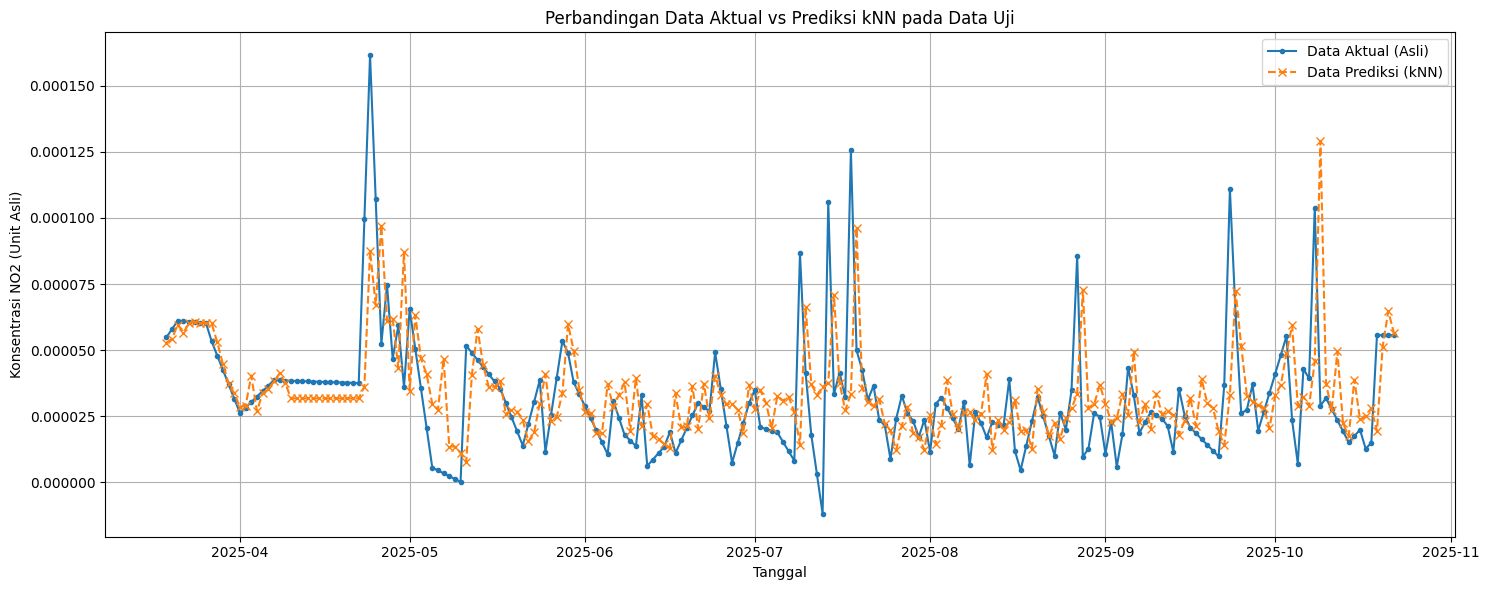

In [20]:
print("Membuat visualisasi perbandingan...")

plt.figure(figsize=(15, 6))
plt.plot(t_test, y_test_orig, label='Data Aktual (Asli)', marker='.', linestyle='-')
plt.plot(t_test, y_pred_orig, label='Data Prediksi (kNN)', marker='x', linestyle='--')
plt.title('Perbandingan Data Aktual vs Prediksi kNN pada Data Uji')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO2 (Unit Asli)')
plt.legend()
plt.grid(True)
plt.tight_layout()

### 9. Residual Analysis

melakukan Analisis Residual (k=5). Anda menghitung error untuk setiap titik data (residual), lalu memplotnya dalam bentuk scatter plot dan histogram untuk memeriksa apakah ada pola dalam error tersebut.

Membuat visualisasi analisis residual...

--- Metrik Residual ---
Mean Residual: -1.842606915427177e-06
Std Dev Residual: 2.126307497282277e-05
Catatan: Mean residual yang mendekati 0 adalah pertanda baik.


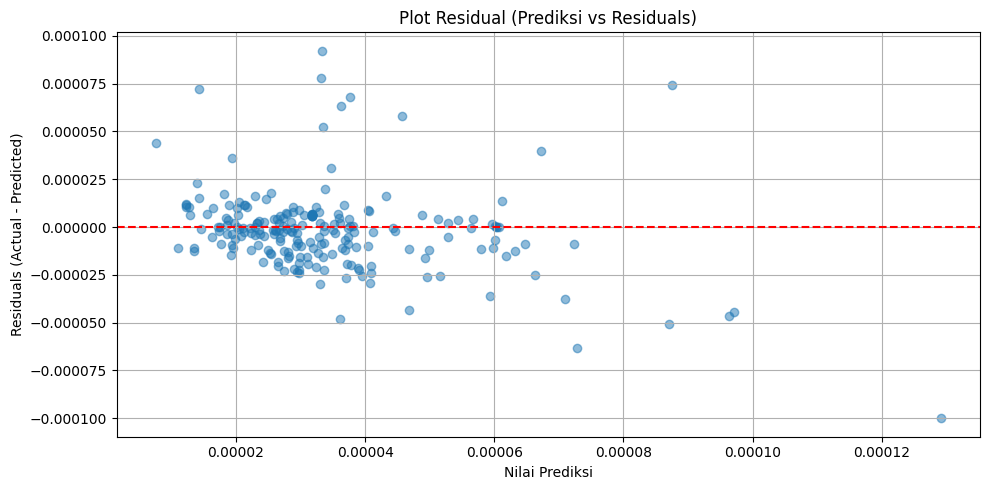

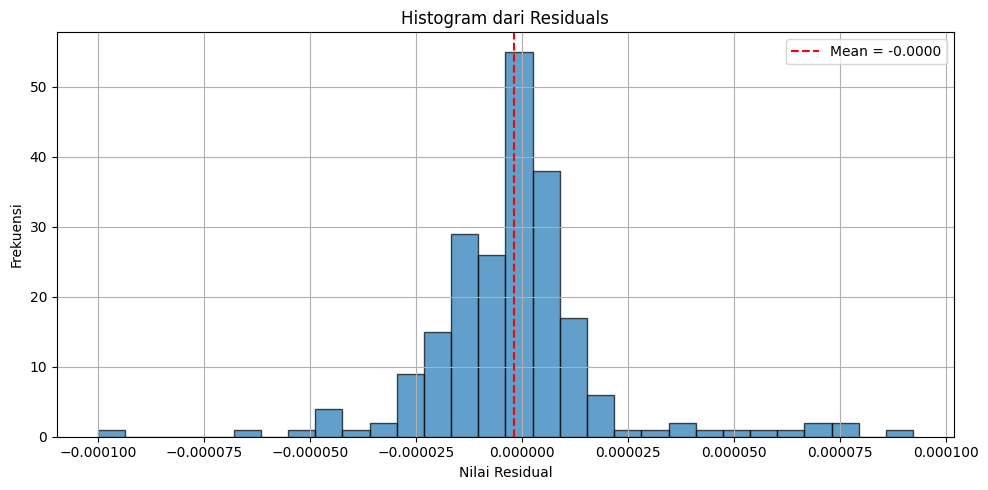

In [21]:
print("Membuat visualisasi analisis residual...")

# A. Hitung Residuals (Actual - Predicted)
residuals = y_test_orig.flatten() - y_pred_orig.flatten()

# B. Hitung Mean dan Std Residual (Permintaan Baru Anda)
mean_resid = residuals.mean()
std_resid = residuals.std()

print("\n--- Metrik Residual ---")
print(f"Mean Residual: {mean_resid}")
print(f"Std Dev Residual: {std_resid}")
print("Catatan: Mean residual yang mendekati 0 adalah pertanda baik.")

# C. Buat Plot Residual (Scatter Plot)
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_orig, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Plot Residual (Prediksi vs Residuals)')
plt.xlabel('Nilai Prediksi')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.tight_layout()

# D. Buat Histogram Residual
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
# Tambahkan garis Mean di histogram
plt.axvline(x=mean_resid, color='red', linestyle='--', label=f'Mean = {mean_resid:.4f}')
plt.title('Histogram dari Residuals')
plt.xlabel('Nilai Residual')
plt.ylabel('Frekuensi')
plt.legend()
plt.grid(True)
plt.tight_layout()

### 10. Hyperparameter Tuning - Mencari K Optimal

melakukan Hyperparameter Tuning. Anda menguji model dengan berbagai nilai $K$ (dari 1 sampai 30) dalam sebuah loop. Untuk setiap $K$, Anda melatih, memprediksi, dan menghitung RMSE. Tujuannya adalah menemukan nilai $K$ yang menghasilkan RMSE terendah.

Memulai pencarian K optimal...
k = 1, RMSE = 2.6110790289918788e-05
k = 2, RMSE = 2.3823519942292477e-05
k = 3, RMSE = 2.272535808330053e-05
k = 4, RMSE = 2.2100872722504976e-05
k = 5, RMSE = 2.1342763587330064e-05
k = 6, RMSE = 2.160283882394288e-05
k = 7, RMSE = 2.141195982111723e-05
k = 8, RMSE = 2.1736663650633034e-05
k = 9, RMSE = 2.1472494527213278e-05
k = 10, RMSE = 2.1081726076145036e-05
k = 11, RMSE = 2.0409567396384075e-05
k = 12, RMSE = 2.042050394222557e-05
k = 13, RMSE = 2.030703542354463e-05
k = 14, RMSE = 2.0093375402622358e-05
k = 15, RMSE = 1.9974066321189194e-05
k = 16, RMSE = 2.0079445584598758e-05
k = 17, RMSE = 1.9973108879526394e-05
k = 18, RMSE = 2.0003464435529218e-05
k = 19, RMSE = 1.9908382830895104e-05
k = 20, RMSE = 1.979955523236225e-05
k = 21, RMSE = 1.973602791538617e-05
k = 22, RMSE = 1.9643544993867e-05
k = 23, RMSE = 1.96469938392496e-05
k = 24, RMSE = 1.9577378225537016e-05
k = 25, RMSE = 1.967001822130577e-05
k = 26, RMSE = 1.9603916531512254e-05
k =

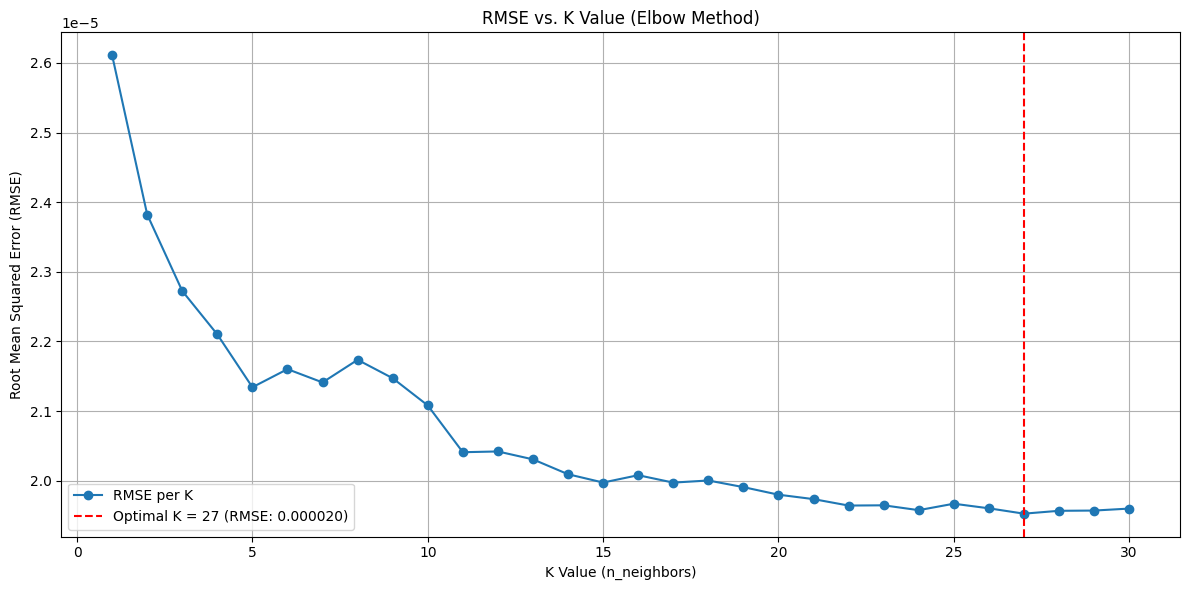

In [22]:
print("Memulai pencarian K optimal...")
rmse_values = [] # Untuk menyimpan nilai RMSE
range_k = range(1, 31) # Kita akan tes K dari 1 sampai 30

# Mengembalikan y_test ke skala asli (hanya perlu sekali)
y_test_orig = target_scaler_z.inverse_transform(y_test.values.reshape(-1, 1))

for k in range_k:
    # 1. Training model dengan K saat ini
    knn_model = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
    knn_model.fit(X_train, y_train)
    
    # 2. Prediksi data test
    y_pred = knn_model.predict(X_test)
    
    # 3. Kembalikan prediksi ke skala asli
    y_pred_orig = target_scaler_z.inverse_transform(y_pred.reshape(-1, 1))
    
    # 4. Hitung RMSE
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    
    # 5. Simpan RMSE
    rmse_values.append(rmse)
    print(f"k = {k}, RMSE = {rmse}")

print("Pencarian K selesai.")

# --- 7. Cari K Terbaik ---
best_rmse = min(rmse_values)
# +1 karena index list mulai dari 0, tapi K kita mulai dari 1
best_k = rmse_values.index(best_rmse) + 1

print("\n--- HASIL K-OPTIMAL ---")
print(f"Nilai K terbaik adalah: {best_k}")
print(f"Dengan nilai RMSE terendah: {best_rmse}")

# --- 8. Visualisasi Elbow Method ---
plt.figure(figsize=(12, 6))
plt.plot(range_k, rmse_values, marker='o', linestyle='-', label='RMSE per K')
plt.title('RMSE vs. K Value (Elbow Method)')
plt.xlabel('K Value (n_neighbors)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
# Tandai K terbaik
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Optimal K = {best_k} (RMSE: {best_rmse:.6f})')
plt.legend()
plt.tight_layout()

### 11. Training dan Evaluasi Model dengan K Optimal

melatih Model Optimal. Setelah menemukan best_k dari sel sebelumnya, Anda membuat dan melatih model baru (final_knn_model) menggunakan nilai $K$ terbaik tersebut.mengevaluasi Model Optimal. Sama seperti evaluasi k=5, Anda membuat prediksi (y_pred_final), mengembalikannya ke skala asli, dan menghitung metrik MAE, MSE, dan RMSE yang baru.

In [24]:
# --- 8. EVALUASI MODEL OPTIMAL (K=best_k) ---
print(f"\n--- 3. Evaluasi Model Optimal (K={best_k}) ---")
optimal_model = KNeighborsRegressor(n_neighbors=best_k, n_jobs=-1)
optimal_model.fit(X_train, y_train)
y_pred_optimal = optimal_model.predict(X_test)
y_pred_optimal_orig = target_scaler_z.inverse_transform(y_pred_optimal.reshape(-1, 1))

mae_optimal = mean_absolute_error(y_test_orig, y_pred_optimal_orig)
mse_optimal = mean_squared_error(y_test_orig, y_pred_optimal_orig)
rmse_optimal = np.sqrt(mse_optimal)

print(f"MAE (K={best_k}):  {mae_optimal}")
print(f"MSE (K={best_k}):  {mse_optimal}")
print(f"RMSE (K={best_k}): {rmse_optimal}")


--- 3. Evaluasi Model Optimal (K=27) ---
MAE (K=27):  1.1978986182215528e-05
MSE (K=27):  3.813079389738831e-10
RMSE (K=27): 1.9527107798490872e-05


### 12. Perbandingan Model Default vs Optimal

membandingkan performa kedua model (k=5 vs k=optimal) secara berdampingan dalam sebuah tabel teks yang rapi.

In [26]:
# --- 9. PERBANDINGAN AKHIR ---
print("\n--- 4. Perbandingan Performa ---")
print(f"                       K=5 (Default)   |   K={best_k} (Optimal)")
print("---------------------------------------------------------------")
print(f"MAE:                   {mae:<15.10f} |   {mae_optimal:<15.10f}")
print(f"MSE:                   {mse:<15.10f} |   {mse_optimal:<15.10f}")
print(f"RMSE:                  {rmse:<15.10f} |   {rmse_optimal:<15.10f}")

print("\n--- Peningkatan Performa (Nilai Lebih Rendah Lebih Baik) ---")
print(f"Peningkatan MAE:  {mae - mae_optimal}")
print(f"Peningkatan MSE:  {mse - mse_optimal}")
print(f"Peningkatan RMSE: {rmse - rmse_optimal}")


--- 4. Perbandingan Performa ---
                       K=5 (Default)   |   K=27 (Optimal)
---------------------------------------------------------------
MAE:                   0.0000135103    |   0.0000119790   
MSE:                   0.0000000005    |   0.0000000004   
RMSE:                  0.0000196001    |   0.0000195271   

--- Peningkatan Performa (Nilai Lebih Rendah Lebih Baik) ---
Peningkatan MAE:  1.5312885849238556e-06
Peningkatan MSE:  7.420561857077896e-11
Peningkatan RMSE: 7.29833827794584e-08


### 13. Visualisasi Hasil Model optimal

memvisualisasikan hasil Model Optimal. Ini adalah plot yang sama dengan sebelumnya, tetapi sekarang menggunakan prediksi dari model k=best_k Anda, yang seharusnya menunjukkan hasil yang (semoga) sedikit lebih baik.

Membuat visualisasi perbandingan model optimal...


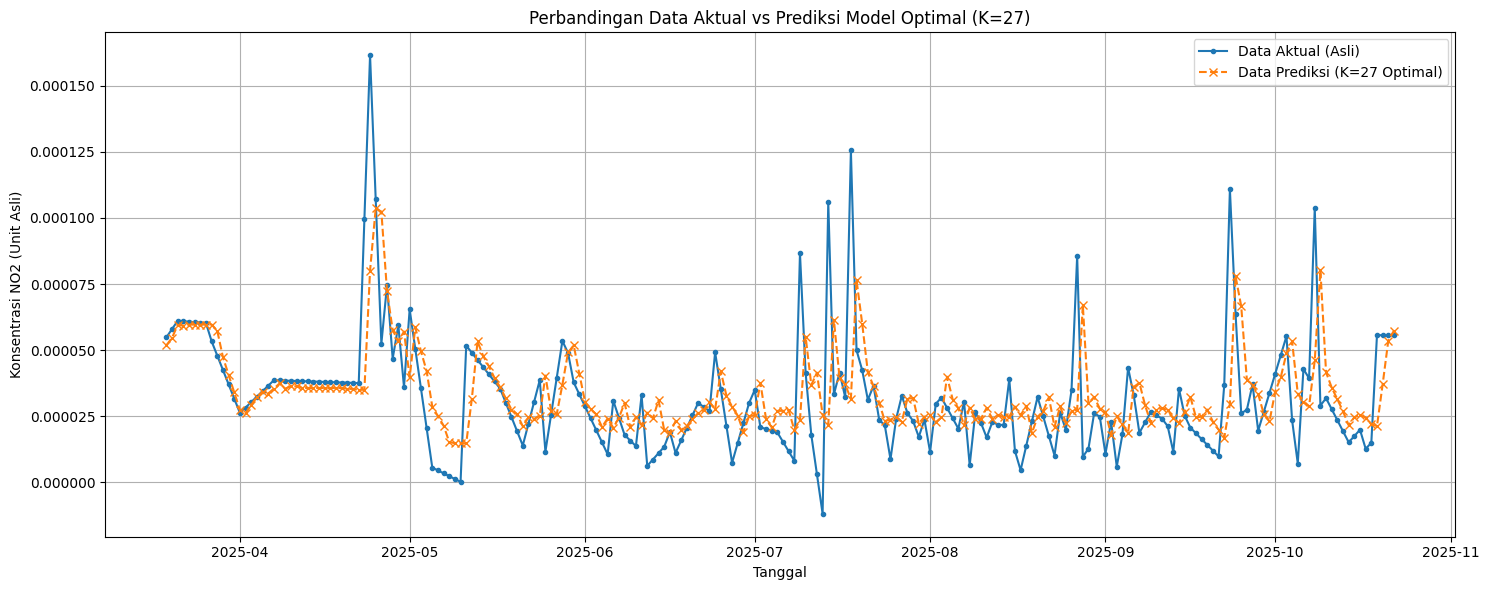

In [27]:
print("Membuat visualisasi perbandingan model optimal...")

plt.figure(figsize=(15, 6))
# Plot data aktual
plt.plot(t_test, y_test_orig, label='Data Aktual (Asli)', marker='.', linestyle='-')
# Plot data prediksi dari model optimal
plt.plot(t_test, y_pred_optimal_orig, label=f'Data Prediksi (K={best_k} Optimal)', marker='x', linestyle='--')
plt.title(f'Perbandingan Data Aktual vs Prediksi Model Optimal (K={best_k})')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO2 (Unit Asli)')
plt.legend()
plt.grid(True)
plt.tight_layout()
